# 回调函数

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os 
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd, sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 2.2.2
numpy 1.19.2
pandas 0.23.0
sklearn 0.23.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [3]:
fashion_mnist = keras.datasets.fashion_mnist #手写数据集
# 输出训练集（数据、标签）、测试集（数据、标签）
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 把数据划分为训练集、测试集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]

y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
'''
    StandardScaler类是一个用来讲数据进行归一化和标准化的类。所谓归一化和标准化，即应用下列公式：
    x = (x - u) /std ，u均值，std方差 -> 使得新的X数据集方差为1，均值为0
    fit_transform(partData)对部分数据先拟合fit，
    找到该part的整体指标，如均值、方差、最大值最小值等等（根据具体转换的目的），
    然后对该partData进行转换transform，从而实现数据的标准化、归一化等等。
    
   问题一：StandardScaler类中transform和fit_transform方法有什么区别？ 
    
    答：fit_transform方法是fit和transform的结合，fit_transform(X_train) 意思是找出X_train的均值和标准差，并应用在X_train上。
    这时对于X_test，我们就可以直接使用transform方法。因为此时StandardScaler已经保存了X_train的均值和标准差
    二者的功能都是对数据进行某种统一处理（比如标准化~N(0,1)，将数据缩放(映射)到某个固定区间，归一化，正则化等）
    fit_transform(partData)对部分数据先拟合fit，找到该part的整体指标，如均值、方差、最大值最小值等等（根据具体转换的目的），然后对该partData进行转换transform，从而实现数据的标准化、归一化等等。。
    根据对之前部分fit的整体指标，对剩余的数据（restData）使用同样的均值、方差、最大最小值等指标进行转换transform(restData)，从而保证part、rest处理方式相同。
    必须先用fit_transform(partData)，之后再transform(restData)
    如果直接transform(partData)，程序会报错;
    如果fit_transfrom(partData)后，使用fit_transform(restData)而不用transform(restData)，虽然也能归一化，但是两个结果不是在同一个“标准”下的，具有明显差异
 
'''

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

# tf.keras.Sequential

In [5]:
# 激活函数：
# relu: y=max(0, x) 当x小于0则y=0,当x大于0则y为x
# softmax: 将向量变成概率分布， x=[x1, x2, x3]
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum= e^x1 + e^x2 + e^x3 

'''
方法1：
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation="relu")) #添加全连接层
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
'''
# 方法2
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [28,28]), 
                                keras.layers.Dense(300, activation="relu"),
                                keras.layers.Dense(100, activation="relu"),
                                keras.layers.Dense(10, activation="softmax")
                                                      ])
          
#当y为索引index是一个数则loss="sparse_categorical_crossentropy"
#当y为one_hot -> [] 则loss="categorical_crossentropy"
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

In [6]:
# Tensorboard, earlystopping, ModelCheckpoint

# 把这个路径用包装一下
logdir = os.path.join("callbacks")
# logdir = "./callbacks"
print(logdir)
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),# 保存效果最好的模型
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]

# 添加回调函数
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)


./callbacks
./callbacks
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 82us/sample - loss: 0.5320 - accuracy: 0.8122 - val_loss: 0.4160 - val_accuracy: 0.8544
Epoch 2/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.3917 - accuracy: 0.8603 - val_loss: 0.3686 - val_accuracy: 0.8702
Epoch 3/10
55000/55000 [==============================] - 3s 60us/sample - loss: 0.3523 - accuracy: 0.8727 - val_loss: 0.3481 - val_accuracy: 0.8748
Epoch 4/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3266 - accuracy: 0.8827 - val_loss: 0.3358 - val_accuracy: 0.8778
Epoch 5/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.3078 - accuracy: 0.8885 - val_loss: 0.3227 - val_accuracy: 0.8850
Epoch 6/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.2916 - accuracy: 0.8931 - val_loss: 0.3256 - val_accuracy: 0.8828
Epoch 7/10
55000/55000 [=========

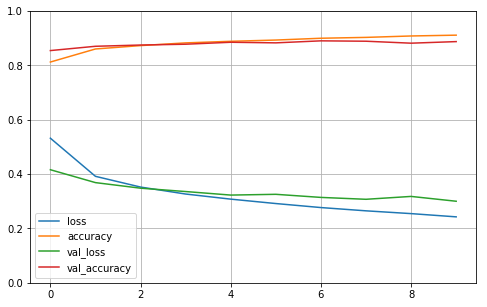

In [7]:
# 打印学习曲线图
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True) #设置网格
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [8]:
# 在测试集上进行测试
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3460548923254013, 0.8753]